In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import spearmanr, kruskal
import seaborn as sns
import matplotlib.patches as mpatches
import statsmodels.api as sm

In [ ]:
#Combining all 4 quarters into one dataframe
csv_files = ['historical_data2023\historical_data_2023Q1.txt', 'historical_data2023\historical_data_2023Q2.txt', 'historical_data2023\historical_data_2023Q3.txt', 'historical_data2023\historical_data_2023Q4.txt']

df_list = [pd.read_csv(file, sep = '|', header = None) for file in csv_files]

merged_df = pd.concat(df_list, ignore_index=True)

merged_df.columns = ['Credit Score', 'First Payment Date', 'First Time Homebuyer Flag', 'Maturity Date', 'MSA', 'MI %', 'Units', 'Occupancy Status',
              'CLTV', 'DTI', 'Original UPB', 'Original LTV', 'Original Interest Rate', 'Channel', 'Prepayment Penalty Mortgage Flag', 'Amortization Type',
              'Property State', 'Property Type', 'Postal Code', 'Loan Sequence Number', 'Loan Purpose', 'Original Loan Term', 'Number of Borrowers', 'Seller Name',
              'Servicer Name', 'Super Conforming Flag', 'Pre-HARP Loan Sequence Number', 'Program Indicator', 'HARP Indicator', 'Property Valuation Method',
              'Interest Only Indicator', 'Mortgage Insurance Cancellation Indicator']

merged_df.to_csv('historical_data_2023.csv', index = False)

FileNotFoundError: [Errno 2] No such file or directory: 'historical_data2023\\historical_data_2023Q1.txt'

In [ ]:
#Loading the dataset
raw_df = pd.read_csv('historical_data_2023.csv')

#Feature Selection
columns_to_keep = ['Credit Score','First Time Homebuyer Flag','DTI','Original LTV','Number of Borrowers','Original Interest Rate','Original Loan Term','Amortization Type','Interest Only Indicator','Loan Purpose','Channel','Property Type','Property State','Units','Occupancy Status']

df = raw_df[columns_to_keep]

In [ ]:
#Checking Categorical Variables for Unexpected Values
print('First Time Homebuyer Flag: ',df['First Time Homebuyer Flag'].unique())
print('Number of Borrowers: ',df['Number of Borrowers'].unique())
print('Amortization Type: ',df['Amortization Type'].unique())
print('Interest Only Indicator: ',df['Interest Only Indicator'].unique())
print('Loan Purpose: ',df['Loan Purpose'].unique())
print('Channel: ',df['Channel'].unique())
print('Property Type: ',df['Property Type'].unique())
print('Property State: ',df['Property State'].unique())
print('Units: ',df['Units'].unique())
print('Occupancy Status: ',df['Occupancy Status'].unique())

#Checking Continuous Variables for Unexpected Values
print(df['Credit Score'].describe())
print(df['DTI'].describe())
print(df['Original LTV'].describe())
print(df['Original Interest Rate'].describe())
print(df['Original Loan Term'].describe())

#Check for Duplicates (Basing it off the raw dataset as it contains the unique loan sequence number)
print('Duplicates: ', raw_df.duplicated().sum()) #No duplicates

#Check for Columns with only one unique value
for col in df.columns:
    if df[col].nunique() == 1:
        print(f"{col} has only one unique value: {df[col].unique()[0]}")
        #Amortization Type only has value 'FRM'
        #Interest Only Indicator only has value 'N'

#Dropping the columns with only one unique value
df = df.drop(columns=['Amortization Type', 'Interest Only Indicator'])


First Time Homebuyer Flag:  ['N' 'Y']
Number of Borrowers:  [1 2 3 4 5]
Amortization Type:  ['FRM']
Interest Only Indicator:  ['N']
Loan Purpose:  ['P' 'C' 'N']
Channel:  ['C' 'R' 'B' '9']
Property Type:  ['SF' 'PU' 'MH' 'CO' 'CP']
Property State:  ['FL' 'KY' 'CO' 'MO' 'MD' 'MN' 'MI' 'TX' 'IL' 'IN' 'CA' 'UT' 'KS' 'VT'
 'NY' 'NH' 'MA' 'HI' 'IA' 'PA' 'OR' 'TN' 'VA' 'DE' 'WI' 'OK' 'SC' 'GA'
 'ME' 'OH' 'WA' 'MT' 'NC' 'LA' 'NE' 'NJ' 'SD' 'CT' 'ID' 'AR' 'AZ' 'RI'
 'AL' 'NV' 'NM' 'ND' 'WV' 'WY' 'DC' 'MS' 'AK' 'PR' 'VI' 'GU']
Units:  [1 2 4 3]
Occupancy Status:  ['I' 'P' 'S']
count    931731.000000
mean        752.664845
std         169.025673
min         300.000000
25%         720.000000
50%         758.000000
75%         786.000000
max        9999.000000
Name: Credit Score, dtype: float64
count    931731.000000
mean         38.165929
std          11.270156
min           1.000000
25%          32.000000
50%          40.000000
75%          46.000000
max         999.000000
Name: DTI, dtype: floa

In [ ]:
#Replacing placeholders with NaN and mapping categorical variables to numerical values
df['First Time Homebuyer Flag'] = df['First Time Homebuyer Flag'].replace({'Y': 1, 'N': 0})
df['Channel'] = df['Channel'].replace({'9': np.nan})
df['Credit Score'] = df['Credit Score'].replace({'9999': np.nan})
df['DTI'] = df['DTI'].replace({'999': np.nan})

<ipython-input-31-a862eaf226f9>:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['First Time Homebuyer Flag'] = df['First Time Homebuyer Flag'].replace({'Y': 1, 'N': 0})


In [ ]:
#Feature Engineering
#DTI Band
df['DTI_Band'] = pd.cut(df['DTI'], bins=[0, 36, 43, 50, 100], labels=['Low', 'Moderate', 'High', 'Extreme'])
#LTV Band
df['LTV_Band'] = pd.cut(df['Original LTV'], bins=[0, 80, 90, 97, 100], labels=['Low Risk (≤80%)', 'Moderate (81-90%)', 'Elevated (91-97%)', 'High (98-100%)'])
#df['LTV_Band'].value_counts(dropna=False)
#Credit Score Band
df['Credit_Band'] = pd.cut(df['Credit Score'], bins=[300, 579, 669, 739, 799, 850], labels=['Poor', 'Fair', 'Good', 'Very Good', 'Excellent'])
#Investment Purchase Flag
df['Investment_Purchase_Flag'] = ((df['Loan Purpose'] == 'Purchase') & (df['Occupancy Status'] == 'Investor')).astype(int)
#Multiple Borrowers Flag
df['Multiple_Borrowers_Flag'] = (df['Number of Borrowers'] > 1).astype(int)

Subquestion 1

Spearman Correlation Matrix:
                           Original Interest Rate  Credit Score       DTI  \
Original Interest Rate                   1.000000     -0.115592  0.045469   
Credit Score                            -0.115592      1.000000 -0.150658   
DTI                                      0.045469     -0.150658  1.000000   
Original LTV                             0.059764     -0.096547  0.122395   
Number of Borrowers                      0.038640     -0.087888 -0.060114   
First Time Homebuyer Flag               -0.060185     -0.086092 -0.002422   
Multiple_Borrowers_Flag                  0.036585     -0.082295 -0.066714   

                           Original LTV  Number of Borrowers  \
Original Interest Rate         0.059764             0.038640   
Credit Score                  -0.096547            -0.087888   
DTI                            0.122395            -0.060114   
Original LTV                   1.000000            -0.022156   
Number of Borrowers           -0.0

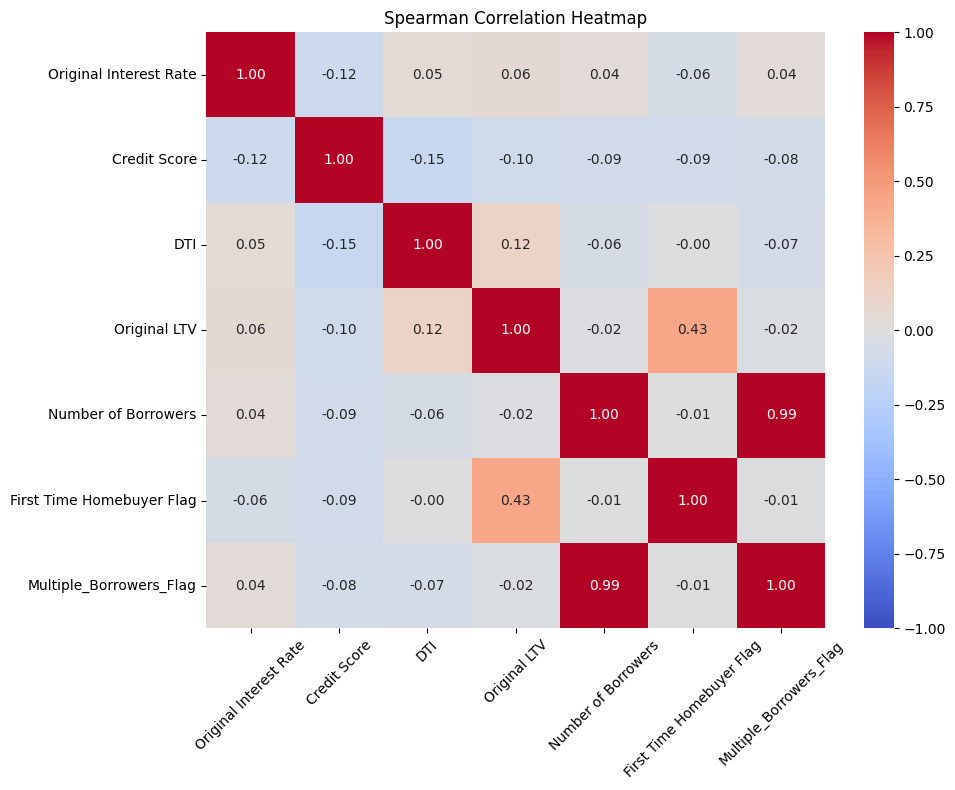

In [ ]:
#Subquestion 1
from matplotlib import pyplot as plt
from scipy.stats import spearmanr
import seaborn as sns

cols = ['Original Interest Rate', 'Credit Score', 'DTI', 'Original LTV', 'Number of Borrowers', 'First Time Homebuyer Flag', 'Multiple_Borrowers_Flag']
data = df[cols].copy()

# Compute Spearman correlation matrix
corr_matrix, p_matrix = spearmanr(data)
corr_df = pd.DataFrame(corr_matrix, index=cols, columns=cols)
pval_df = pd.DataFrame(p_matrix, index=cols, columns=cols)

# Display
print("Spearman Correlation Matrix:")
print(corr_df)

print("\nP-Value Matrix:")
print(pval_df)

plt.figure(figsize=(10, 8))

#Mask p-values>0.05
mask = pval_df > 0.05

# Create the heatmap
sns.heatmap(corr_df, annot=True, fmt=".2f", cmap="coolwarm", vmin=-1, vmax=1, mask = mask)

# Set titles and labels
plt.title("Spearman Correlation Heatmap")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()

# Show the plot
plt.show()

Subquestion 2

In [ ]:
#Checking the distribution of the Credit Score Band
print(df['Credit_Band'].value_counts(dropna=False))

Credit_Band
Very Good    483153
Good         288613
Excellent    106861
Fair          52810
NaN             292
Poor              2
Name: count, dtype: int64


<ipython-input-35-8ef6f5f5c69f>:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  medians = data.groupby(attr)['Original Interest Rate'].median().loc[order].reset_index()
<ipython-input-35-8ef6f5f5c69f>:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=attr, y='Original Interest Rate', data=data, order=order, palette='viridis')


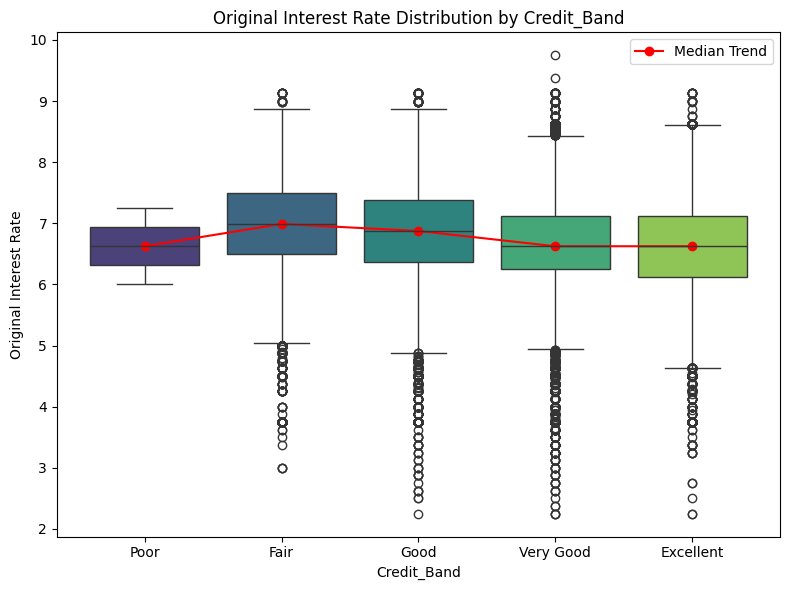

<ipython-input-35-8ef6f5f5c69f>:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  medians = data.groupby(attr)['Original Interest Rate'].median().loc[order].reset_index()
<ipython-input-35-8ef6f5f5c69f>:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=attr, y='Original Interest Rate', data=data, order=order, palette='viridis')


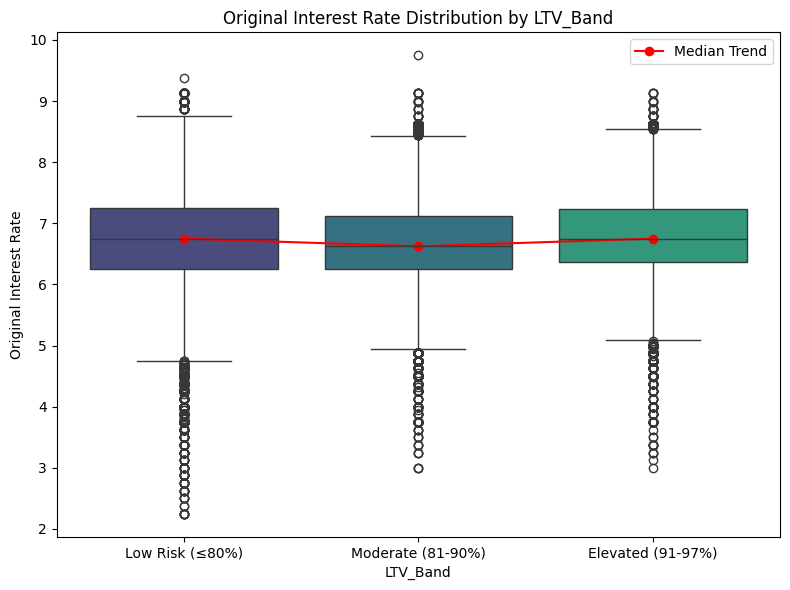

<ipython-input-35-8ef6f5f5c69f>:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  medians = data.groupby(attr)['Original Interest Rate'].median().loc[order].reset_index()
<ipython-input-35-8ef6f5f5c69f>:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=attr, y='Original Interest Rate', data=data, order=order, palette='viridis')


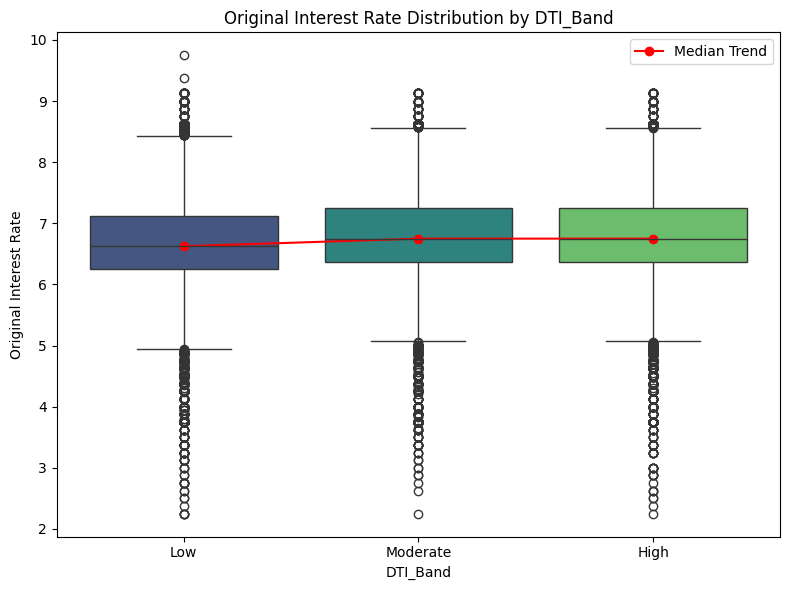

In [ ]:
#Subquestion 2:
import matplotlib.pyplot as plt
import seaborn as sns

category_orders = {
    'Credit_Band': ['Poor', 'Fair', 'Good', 'Very Good', 'Excellent'],
    'LTV_Band': ['Low Risk (≤80%)', 'Moderate (81-90%)', 'Elevated (91-97%)', 'High (98-100%)'],
    # Update these levels as appropriate for your data.
    'DTI_Band': ['Low', 'Moderate', 'High']
}

data = df.copy()


risk_attributes = ['Credit_Band', 'LTV_Band', 'DTI_Band']

for attr in risk_attributes:
    order = category_orders[attr]
    medians = data.groupby(attr)['Original Interest Rate'].median().loc[order].reset_index()
    plt.figure(figsize=(8, 6))
    sns.boxplot(x=attr, y='Original Interest Rate', data=data, order=order, palette='viridis')
    plt.plot(medians[attr], medians['Original Interest Rate'],
             marker='o', linestyle='-', color='red', label='Median Trend')
    plt.title(f'Original Interest Rate Distribution by {attr}')
    plt.xlabel(attr)
    plt.ylabel('Original Interest Rate')
    plt.legend()
    plt.tight_layout()
    plt.show()


Subquestion 3

In [ ]:
#Subquestion 3
import statsmodels.formula.api as smf

data = df.copy()
formula = (
    'Q("Original Interest Rate") ~ '
    'Q("Credit Score") * Q("Original LTV") + '
    'Q("Credit Score") * Q("DTI") + '
    'Q("Original LTV") * Q("DTI") + '
    'C(Credit_Band) + '
    'C(LTV_Band) + '
    'C(DTI_Band) + '
    'C(Q("First Time Homebuyer Flag")) + '
    'C(Q("Multiple_Borrowers_Flag"))'
)

model = smf.ols(formula, data=data).fit()
print(model.summary())

                                 OLS Regression Results                                
Dep. Variable:     Q("Original Interest Rate")   R-squared:                       0.034
Model:                                     OLS   Adj. R-squared:                  0.034
Method:                          Least Squares   F-statistic:                     1930.
Date:                         Mon, 07 Apr 2025   Prob (F-statistic):               0.00
Time:                                 08:57:48   Log-Likelihood:            -9.6208e+05
No. Observations:                       931398   AIC:                         1.924e+06
Df Residuals:                           931380   BIC:                         1.924e+06
Df Model:                                   17                                         
Covariance Type:                     nonrobust                                         
                                             coef    std err          t      P>|t|      [0.025      0.975]
-------------

Subquestion 4

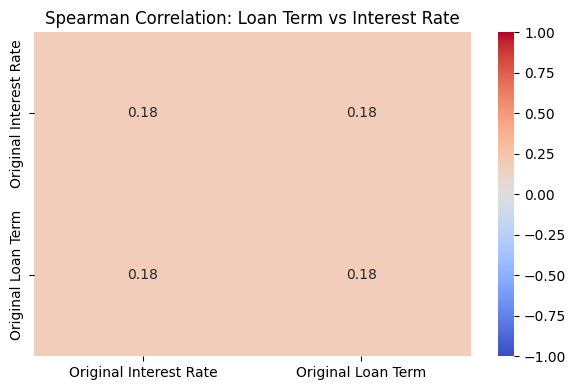

Kruskal-Wallis Test for Loan Term Bands — H-statistic: 34738.6667 | p-value: 0.0000


In [ ]:
# Subquestion 4: Impact of Loan Terms on Interest Rates

cols = ['Original Interest Rate', 'Original Loan Term']
data = df[cols].dropna()

corr_matrix, p_matrix = spearmanr(data)
corr_df = pd.DataFrame(corr_matrix, index=cols, columns=cols)
pval_df = pd.DataFrame(p_matrix, index=cols, columns=cols)

mask = pval_df > 0.05

plt.figure(figsize=(6, 4))
sns.heatmap(corr_df, annot=True, fmt=".2f", cmap="coolwarm", vmin=-1, vmax=1, mask=mask)
plt.title("Spearman Correlation: Loan Term vs Interest Rate")
plt.tight_layout()
plt.show()

df['Loan_Term_Band'] = pd.cut(df['Original Loan Term'],
                               bins=[0, 180, 240, 300, 360, 370],
                               labels=['≤180 mo', '181-240 mo', '241-300 mo', '301-360 mo', '361-366 mo'])

feature = 'Loan_Term_Band'
temp_df = df[[feature, 'Original Interest Rate']].dropna()

groups = [temp_df[temp_df[feature] == category]['Original Interest Rate']
          for category in temp_df[feature].unique()
          if len(temp_df[temp_df[feature] == category]) > 1]

stat, p = kruskal(*groups)
print(f"Kruskal-Wallis Test for Loan Term Bands — H-statistic: {stat:.4f} | p-value: {p:.4f}")


Subquestion 5

In [ ]:
data = df.copy()
data['Amortization Type'].unique()

KeyError: 'Amortization Type'

Subquestion 6

<ipython-input-39-f06427a1c21c>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=state_avg.index, y=state_avg.values, palette=palette)


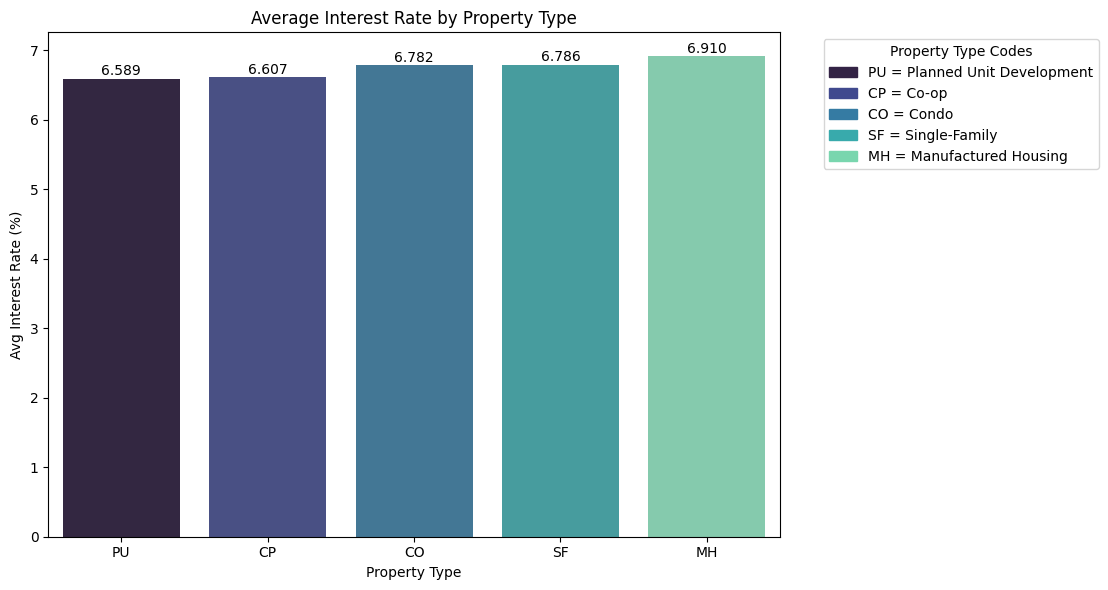

In [ ]:
# Property Type vs Interest Rate

# Group and sort data
state_avg = df.groupby('Property Type')['Original Interest Rate'].mean().sort_values()

# Define color palette and apply it to the barplot
palette = sns.color_palette('mako', n_colors=len(state_avg))

# Create barplot
plt.figure(figsize=(8, 6))
ax = sns.barplot(x=state_avg.index, y=state_avg.values, palette=palette)
plt.title('Average Interest Rate by Property Type')
plt.ylabel('Avg Interest Rate (%)')
plt.xlabel('Property Type')
plt.tight_layout()

# Add value labels to bars
for i, bar in enumerate(ax.patches):
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        height + 0.01,
        f'{height:.3f}',
        ha='center', va='bottom', fontsize=10
    )

# Custom legend mapping abbreviations to full labels
legend_labels = {
    'CO': 'Condo',
    'PU': 'Planned Unit Development',
    'MH': 'Manufactured Housing',
    'SF': 'Single-Family',
    'CP': 'Co-op'
}

# Create colored legend patches (using actual colors from palette)
patches = []
for i, code in enumerate(state_avg.index):
    if code in legend_labels:
        label = f"{code} = {legend_labels[code]}"
        patches.append(mpatches.Patch(color=palette[i], label=label))

# Add legend
plt.legend(handles=patches, title='Property Type Codes', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

Subquestion 7

<ipython-input-40-8a64ede09eb0>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=occ_status.index, y=occ_status.values, palette='mako')


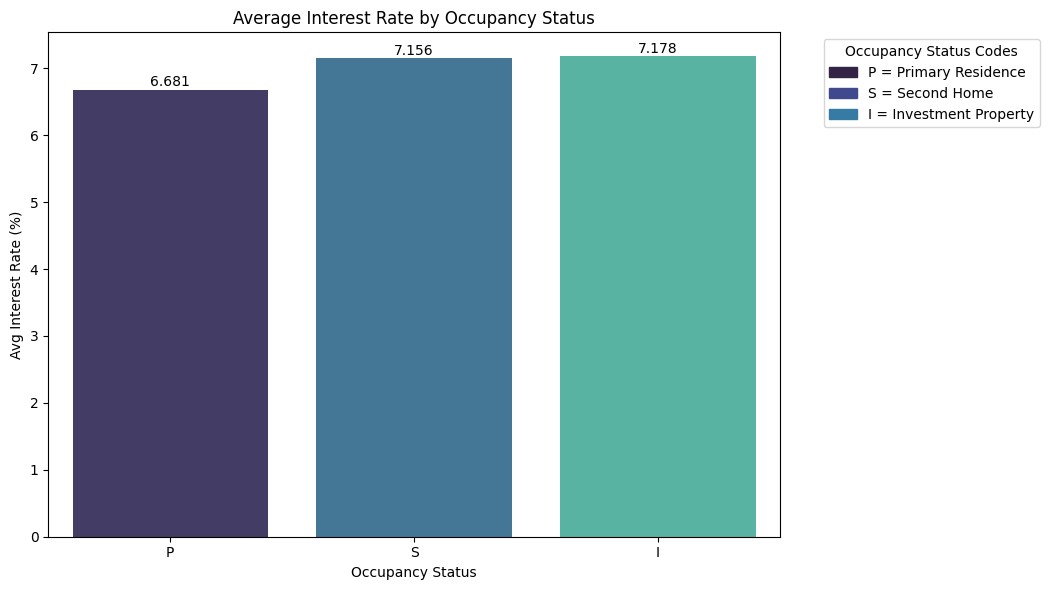

In [ ]:
# Visualize average interest rates by occupancy

occ_status = df.groupby('Occupancy Status')['Original Interest Rate'].mean().sort_values()


# Create plot
plt.figure(figsize=(8, 6))
ax = sns.barplot(x=occ_status.index, y=occ_status.values, palette='mako')
plt.title('Average Interest Rate by Occupancy Status')
plt.ylabel('Avg Interest Rate (%)')
plt.xlabel('Occupancy Status')
plt.tight_layout()

# Add value labels on each bar
for i, bar in enumerate(ax.patches):
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2,  # X position
        height + 0.002,                    # Y position slightly above the bar
        f'{height:.3f}',                   # Label format
        ha='center', va='bottom', fontsize=10
    )

# Custom legend mapping abbreviations to full labels
legend_labels = {
    'P': 'Primary Residence',
    'I': 'Investment Property',
    'S': 'Second Home'

}

# Create colored legend patches (using actual colors from palette)
patches = []
for i, code in enumerate(occ_status.index):
    if code in legend_labels:
        label = f"{code} = {legend_labels[code]}"
        patches.append(mpatches.Patch(color=palette[i], label=label))

# Add legend
plt.legend(handles=patches, title='Occupancy Status Codes', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()


<ipython-input-41-1f90321a72fc>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=property_state.index, y=property_state.values, palette='coolwarm')


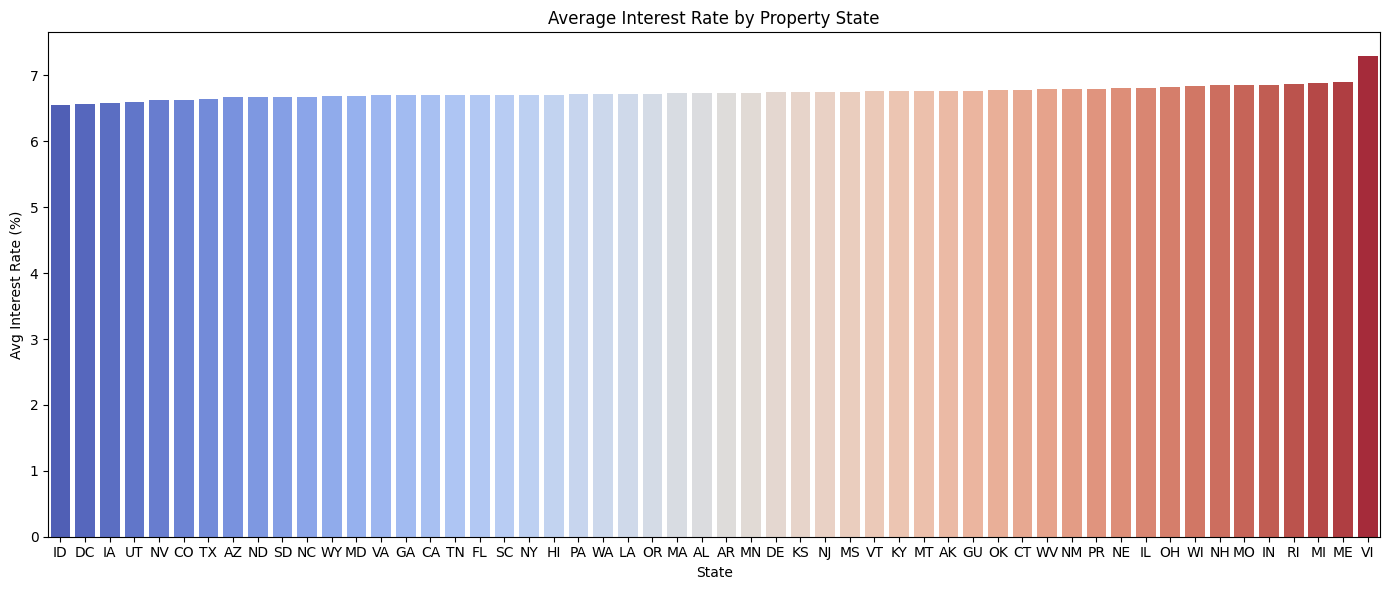

In [ ]:
# Visualize average interest rates by state

property_state = df.groupby('Property State')['Original Interest Rate'].mean().sort_values()


plt.figure(figsize=(14, 6))
sns.barplot(x=property_state.index, y=property_state.values, palette='coolwarm')
plt.title('Average Interest Rate by Property State')
plt.xlabel('State')
plt.ylabel('Avg Interest Rate (%)')
plt.tight_layout()
plt.show()




<ipython-input-42-1f54b2dd9ca7>:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=lowest_states.index, y=lowest_states.values, palette='Blues_d')


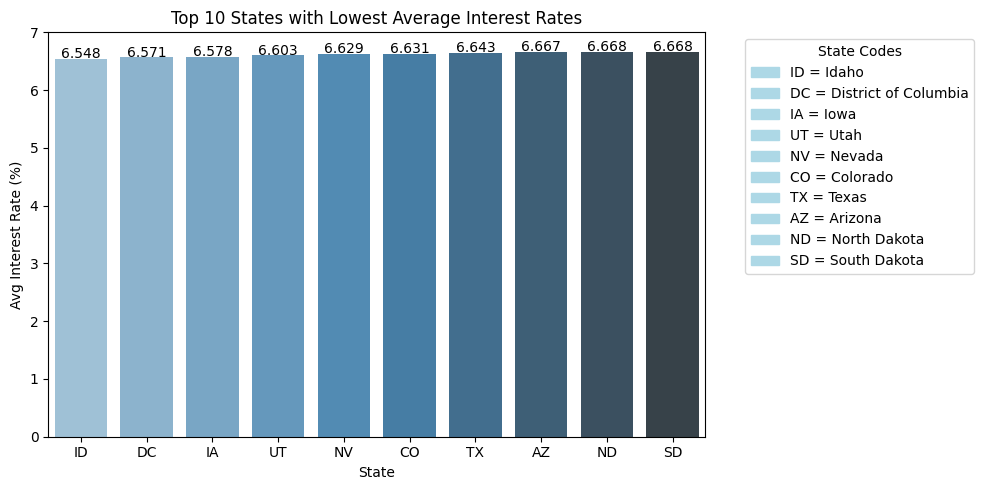

<ipython-input-42-1f54b2dd9ca7>:65: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=highest_states.index, y=highest_states.values, palette='Reds_d')


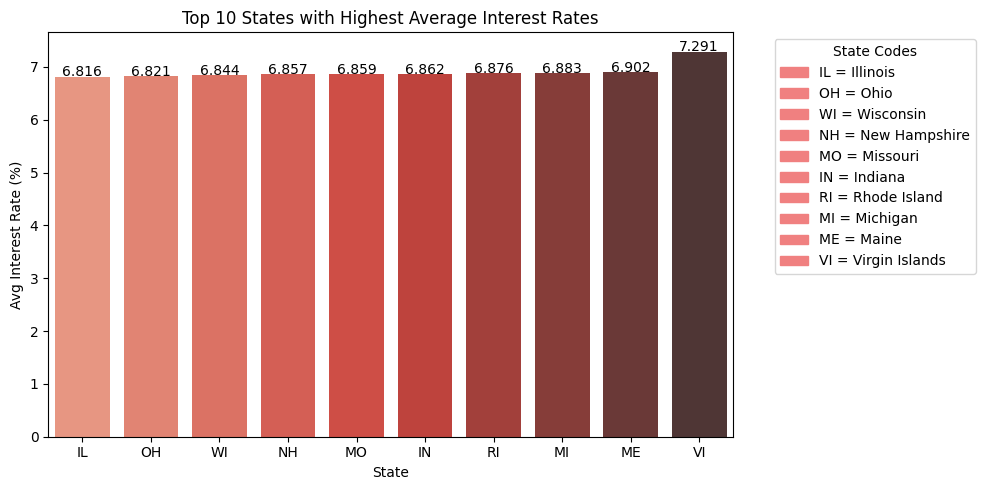

In [ ]:
# VIsualize top 10 and bottom 10 states by interest rate

# Compute average interest rate per state
property_state = df.groupby('Property State')['Original Interest Rate'].mean().sort_values()

# Split into top 10 lowest and top 10 highest
lowest_states = property_state.head(10)
highest_states = property_state.tail(10)

# State abbreviation to full name (top 10 lowest)
lowest_legend_labels = {
    'ID': 'Idaho',
    'DC': 'District of Columbia',
    'IA': 'Iowa',
    'UT': 'Utah',
    'NV': 'Nevada',
    'CO': 'Colorado',
    'TX': 'Texas',
    'AZ': 'Arizona',
    'ND': 'North Dakota',
    'SD': 'South Dakota'
}

# Create legend patches for lowest
lowest_patches = [mpatches.Patch(color='lightblue', label=f"{abbr} = {name}")
                  for abbr, name in lowest_legend_labels.items()]

# Plot lowest 10 states
plt.figure(figsize=(10, 5))
sns.barplot(x=lowest_states.index, y=lowest_states.values, palette='Blues_d')
plt.title('Top 10 States with Lowest Average Interest Rates')
plt.ylabel('Avg Interest Rate (%)')
plt.xlabel('State')

# Add value labels
for i, v in enumerate(lowest_states.values):
    plt.text(i, v + 0.01, f'{v:.3f}', ha='center')

# Add legend
plt.legend(handles=lowest_patches, title='State Codes', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


# State abbreviation to full name (top 10 highest)
highest_legend_labels = {
    'IL': 'Illinois',
    'OH': 'Ohio',
    'WI': 'Wisconsin',
    'NH': 'New Hampshire',
    'MO': 'Missouri',
    'IN': 'Indiana',
    'RI': 'Rhode Island',
    'MI': 'Michigan',
    'ME': 'Maine',
    'VI': 'Virgin Islands'
}

# Create legend patches for highest
highest_patches = [mpatches.Patch(color='lightcoral', label=f"{abbr} = {name}")
                   for abbr, name in highest_legend_labels.items()]

# Plot highest 10 states
plt.figure(figsize=(10, 5))
sns.barplot(x=highest_states.index, y=highest_states.values, palette='Reds_d')
plt.title('Top 10 States with Highest Average Interest Rates')
plt.ylabel('Avg Interest Rate (%)')
plt.xlabel('State')

# Add value labels
for i, v in enumerate(highest_states.values):
    plt.text(i, v + 0.01, f'{v:.3f}', ha='center')

# Add legend
plt.legend(handles=highest_patches, title='State Codes', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

Subquestion 8

                              OLS Regression Results                              
Dep. Variable:     Original Interest Rate   R-squared:                       0.084
Model:                                OLS   Adj. R-squared:                  0.084
Method:                     Least Squares   F-statistic:                     7776.
Date:                    Mon, 07 Apr 2025   Prob (F-statistic):               0.00
Time:                            08:58:14   Log-Likelihood:            -9.3765e+05
No. Observations:                  931731   AIC:                         1.875e+06
Df Residuals:                      931719   BIC:                         1.875e+06
Df Model:                              11                                         
Covariance Type:                nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------

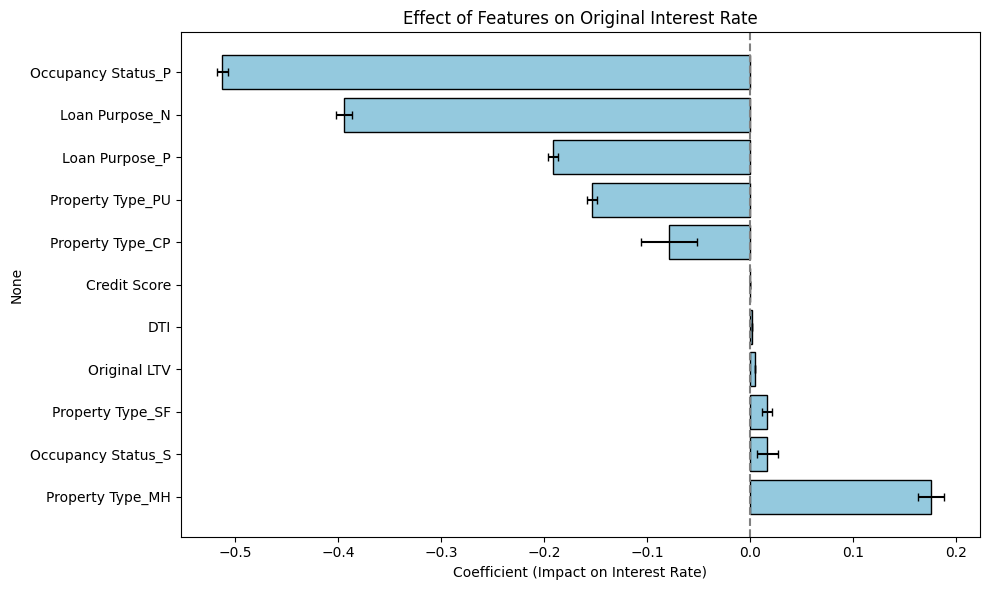

In [ ]:
# multivariate analysis

# 1. Select features for analysis
features = ['Credit Score', 'Original LTV', 'DTI',
            'Loan Purpose', 'Occupancy Status', 'Property Type']

# 2. Clean and drop missing data
df_clean = df[features + ['Original Interest Rate']].dropna()

# 3. Convert categorical features to category dtype
for feature in features:
    if df_clean[feature].dtype == 'object':
        df_clean[feature] = pd.Categorical(df_clean[feature])

# 4. One-hot encode categorical variables
df_encoded = pd.get_dummies(df_clean,
                            columns=['Loan Purpose', 'Occupancy Status', 'Property Type'],
                            drop_first=True,
                            dtype=float)

# 5. Define X and y
X = df_encoded.drop('Original Interest Rate', axis=1)
y = df_encoded['Original Interest Rate']

# 6. Add constant and ensure float dtype
X = sm.add_constant(X).astype(float)
y = y.astype(float)

# 7. Fit OLS regression
model = sm.OLS(y, X).fit()

# 8. Display regression summary
print(model.summary())

# 9. Visualize coefficients
coef = model.params
conf = model.conf_int()
conf.columns = ['lower_bound', 'upper_bound']

coef_df = pd.concat([coef, conf], axis=1)
coef_df.columns = ['coefficient', 'lower_bound', 'upper_bound']
coef_df = coef_df.drop('const', errors='ignore').sort_values(by='coefficient')

# Plotting
plt.figure(figsize=(10, 6))
sns.barplot(x=coef_df['coefficient'], y=coef_df.index, color='skyblue', edgecolor='black')

# Error bars
plt.errorbar(coef_df['coefficient'], coef_df.index,
             xerr=(coef_df['coefficient'] - coef_df['lower_bound'],
                   coef_df['upper_bound'] - coef_df['coefficient']),
             fmt='none', c='black', capsize=3)

plt.axvline(0, color='gray', linestyle='--')
plt.title('Effect of Features on Original Interest Rate')
plt.xlabel('Coefficient (Impact on Interest Rate)')
plt.tight_layout()
plt.show()


Subquestion 9

In [ ]:
# Subquestion 9: Predictive Modeling for Interest Rate Pricing

import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt

# Load 10,000 rows from cleaned dataset for memory-safe regression
df = pd.read_csv('historical_data_2023_cleaned.csv', nrows=10000)

# Drop missing values
df = df.dropna()

# Define predictors and target
features = [
    'Credit Score', 'DTI', 'Original LTV', 'Original Loan Term',
    'First Time Homebuyer Flag', 'Number of Borrowers',
    'Loan Purpose', 'Channel', 'Property Type', 'Property State',
    'Occupancy Status', 'Units'
]
target = 'Original Interest Rate'

# Split predictors and target
X = df[features]
y = df[target]

# Define categorical and numerical features
categorical_features = ['Loan Purpose', 'Channel', 'Property Type', 'Property State', 'Occupancy Status']
numerical_features = list(set(features) - set(categorical_features))

# Preprocessing: one-hot encode categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)

# Create pipeline: preprocess + linear regression
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# Fit the model
model.fit(X, y)

# Predict and evaluate
y_pred = model.predict(X)
r2 = r2_score(y, y_pred)
rmse = np.sqrt(mean_squared_error(y, y_pred))

# Extract feature importance (coefficients)
regressor = model.named_steps['regressor']
encoded_feature_names = numerical_features + list(
    model.named_steps['preprocessor'].transformers_[1][1].get_feature_names_out(categorical_features)
)
coefficients = pd.Series(regressor.coef_, index=encoded_feature_names).sort_values(key=np.abs, ascending=False)

# Output performance and top 10 predictors
print(f"R² Score: {r2:.3f}")
print(f"RMSE: {rmse:.3f}")
print("\nTop 10 Most Influential Features:")
print(coefficients.head(10))

ValueError: Found array with 0 sample(s) (shape=(0,)) while a minimum of 1 is required.

Subquestion 10

In [ ]:
# Subquestion 10: Predictive Modeling for Interest Rate Pricing

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

df = pd.read_csv('historical_data_2023_cleaned.csv', nrows=10000).dropna()

# Define feature columns and target variable
features = [
    'Credit Score', 'DTI', 'Original LTV', 'Original Loan Term',
    'First Time Homebuyer Flag', 'Number of Borrowers',
    'Loan Purpose', 'Channel', 'Property Type', 'Property State',
    'Occupancy Status', 'Units'
]
target = 'Original Interest Rate'

# Split features and target
X = df[features]
y = df[target]

# Separate categorical and numerical features
categorical_features = ['Loan Purpose', 'Channel', 'Property Type', 'Property State', 'Occupancy Status']
numerical_features = list(set(features) - set(categorical_features))

# Define preprocessing for categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define machine learning models
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(random_state=42)
}

# Evaluate each model and store results
results = {}

for name, model in models.items():
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', model)
    ])

    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)

    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    results[name] = {'R²': round(r2, 3), 'RMSE': round(rmse, 3)}

# Print results
for model, metrics in results.items():
    print(f"{model} — R²: {metrics['R²']} | RMSE: {metrics['RMSE']}")

ValueError: With n_samples=0, test_size=0.2 and train_size=None, the resulting train set will be empty. Adjust any of the aforementioned parameters.

Subquestion 11

In [ ]:
# Subquestion 11: Predictive Modeling for Interest Rate Pricing

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression

# Load and prepare dataset (10,000 row sample)
df = pd.read_csv('historical_data_2023_cleaned.csv', nrows=10000).dropna()

# Define features and target
features = [
    'Credit Score', 'DTI', 'Original LTV', 'Original Loan Term',
    'First Time Homebuyer Flag', 'Number of Borrowers',
    'Loan Purpose', 'Channel', 'Property Type', 'Property State',
    'Occupancy Status', 'Units'
]
target = 'Original Interest Rate'

# Prepare feature and target data
X = df[features]
y = df[target]

# Identify categorical vs numerical features
categorical_features = ['Loan Purpose', 'Channel', 'Property Type', 'Property State', 'Occupancy Status']
numerical_features = list(set(features) - set(categorical_features))

# Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Linear Regression model pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])
pipeline.fit(X_train, y_train)

# Predict and calculate residuals
y_pred = pipeline.predict(X_test)
residuals = y_test - y_pred

# Combine predictions and errors
comparison_df = X_test.copy()
comparison_df['Actual Interest Rate'] = y_test
comparison_df['Predicted Interest Rate'] = y_pred
comparison_df['Residual'] = residuals

# Top 5 largest underestimations (model predicted too low)
largest_underestimated = comparison_df.sort_values(by='Residual', ascending=False).head(5)

# Top 5 largest overestimations (model predicted too high)
largest_overestimated = comparison_df.sort_values(by='Residual', ascending=True).head(5)

# Display results
print("\n Top 5 Underestimated Loans (Actual > Predicted):")
print(largest_underestimated[['Actual Interest Rate', 'Predicted Interest Rate', 'Residual']])

print("\n Top 5 Overestimated Loans (Actual < Predicted):")
print(largest_overestimated[['Actual Interest Rate', 'Predicted Interest Rate', 'Residual']])

ValueError: With n_samples=0, test_size=0.2 and train_size=None, the resulting train set will be empty. Adjust any of the aforementioned parameters.